In [83]:
import numpy as np
import pandas as pd
import fastplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import yscale
from numpy import quantile
from pandas import value_counts
%matplotlib inline
import seaborn as sns
from adjustText import adjust_text
import json
import glob
import os

In [84]:
sns.set_style("whitegrid") 
sns.set_context("paper")

# Packet Processing Time

In [158]:
time_threshold = 1000
log_list = sorted(glob.glob("../log/*_stat.csv"), key=os.path.getmtime)
latest_log_file = log_list[-1]
print(latest_log_file)

raw_df = pd.read_csv(latest_log_file)
# raw_df['time'] = raw_df['time'] - raw_df['time'].min()
# raw_df = raw_df[raw_df['time'] < time_threshold]

stats_df = raw_df[raw_df['msg'] == 'stats']
stats_df = stats_df.drop(columns=['level', 'file', 'line', 'msg'])
stats_df.reset_index(inplace=True, drop=True)

pkt_process_time_df = raw_df[raw_df['msg'] == 'pkt_processing_time'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
pkt_process_time_df.columns = ['time', 'sample_at', 'pkt_process_time']
pkt_process_time_df.reset_index(inplace=True)
print(pkt_process_time_df.head())

pkt_pps_df = raw_df[raw_df['msg'] == 'batch_processing_time'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
pkt_pps_df.columns = ['time', 'sample_at', 'kpps']
pkt_pps_df.reset_index(inplace=True, drop=True)
pkt_pps_df = pkt_pps_df[1:]
pkt_pps_df.reset_index(inplace=True, drop=True)
batch_size = pkt_pps_df['sample_at'][1] - pkt_pps_df['sample_at'][0]
pkt_pps_df['kpps'] = (batch_size / pkt_pps_df['kpps']) * 1000000 / 1000
print(pkt_pps_df.head())

timeout_df = raw_df[raw_df['msg'] == 'timeout'][['time', 'pkt_count']]
timeout_df.columns = ['time', 'timeout']
timeout_df.reset_index(inplace=True, drop=True)
print(timeout_df.head())


../log/buf10000_GCsize500_GCperiod1000_T200000_stat.csv
   index          time  sample_at  pkt_process_time
0      1  1.731959e+09       5000              80.0
1      4  1.731959e+09      10000              28.0
2      6  1.731959e+09      15000               6.0
3      9  1.731959e+09      20000              18.0
4     11  1.731959e+09      25000              23.0
           time  sample_at        kpps
0  1.731959e+09      10000  234.005710
1  1.731959e+09      15000  222.400142
2  1.731959e+09      20000  178.132459
3  1.731959e+09      25000  235.760091
4  1.731959e+09      30000  239.223004
           time  timeout
0  1.731959e+09   225825
1  1.731959e+09   214369
2  1.731959e+09   216006
3  1.731959e+09   207002
4  1.731959e+09   208228


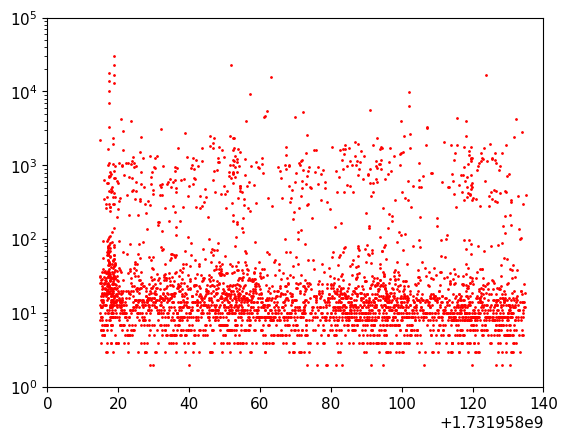

In [131]:
plt.scatter(pkt_process_time_df['time'], pkt_process_time_df['pkt_process_time'], s=1)
# plt.xlim(3.3e7, 3.5e7)
# plt.ylim(0, 2e6)
plt.yscale('log')
plt.show()

In [115]:
# for col in stats_df.columns:
#     plt.cla()
#     plt.scatter(stats_df['time'], stats_df[col], label=col, s=1)
#     plt.legend()
#     plt.show()

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

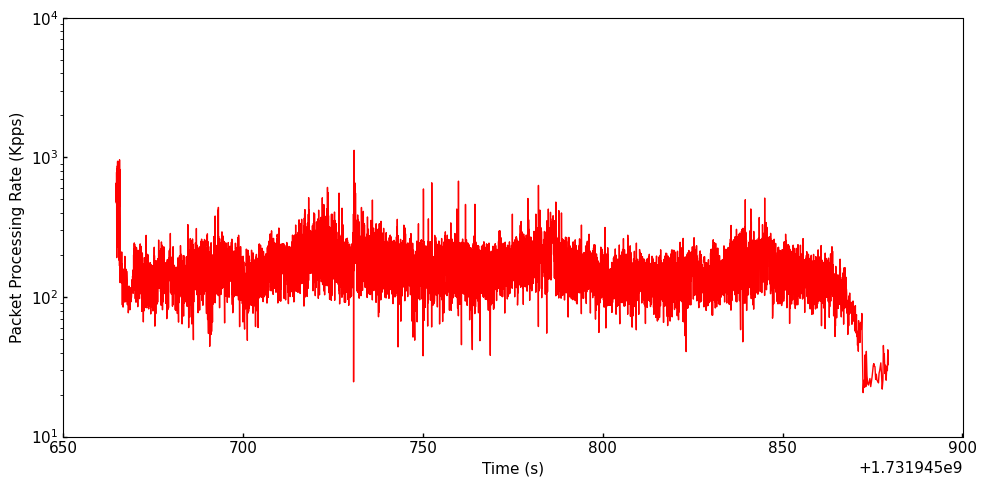

In [ ]:
# fastplot.plot((pkt_pps_df['time'], pkt_pps_df['kpps']), None, mode='line',
#               figsize=(10, 5), xlabel='Time (s)', 
#               yscale='log',
#               ylabel='Packet Processing Rate (Kpps)')

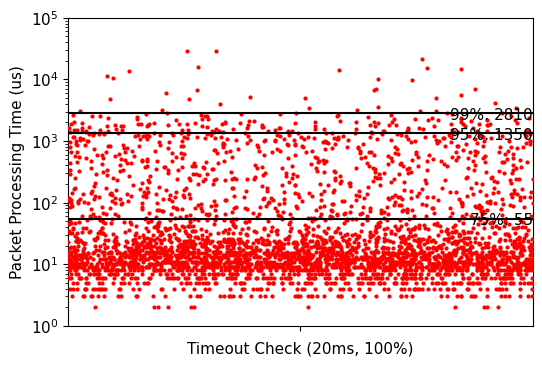

In [159]:
plt.figure(figsize=(6, 4))
sns.stripplot(y='pkt_process_time', 
              size=3, legend=False,
              data=pkt_process_time_df, jitter=0.2)
plt.ylabel('Packet Processing Time (us)')
plt.xlabel('Timeout Check (20ms, 100%)')
plt.yscale('log')


texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = pkt_process_time_df['pkt_process_time'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.25, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))

adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)
plt.show()

# Timeout Bias (real buffered time (avg) - expected buffered time)

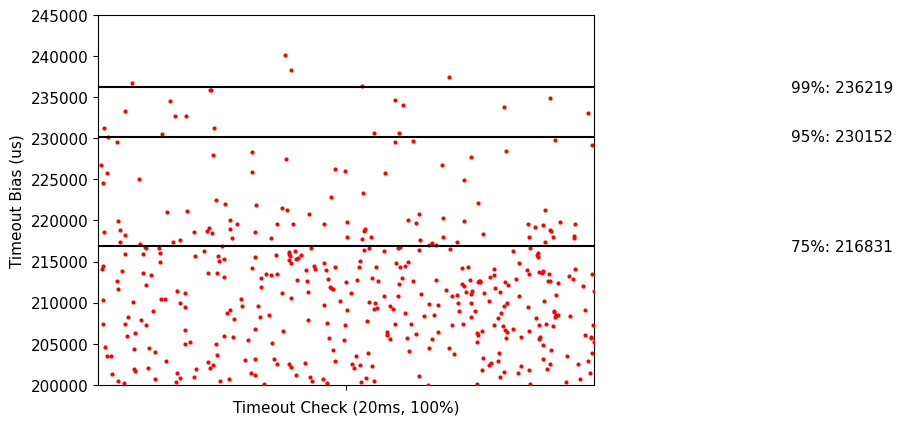

In [155]:

sns.stripplot(y='timeout', 
              size=3, legend=False,
              data=timeout_df, 
              jitter=0.2)
plt.ylabel('Timeout Bias (us)')
plt.xlabel('Timeout Check (20ms, 100%)')

texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = timeout_df['timeout'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.4, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))
# adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)

# Data Structure Usage

In [91]:
from cycler import cycler

mcolor_lists = ['red', 'red', 'blue', 'blue', 'tab:green','tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'b', 'g', 'r', 'c', 'm', 'y', 'k',
                'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'rosybrown', 'tomato', 'yellowgreen', 'lightseagreen', 'navy', 'deeppink',
                'darkslategray', 'darkolivegreen', 'darkcyan', 'darkviolet', 'mediumslateblue', 'darkorange', 'gold', 'peru', 'darkkhaki']
CYCLER_LINES=(cycler('color', mcolor_lists[:30]) +
              cycler('linestyle', ['-', '--','-', '--','-', '--','-', '--', '-.', ':', (0, (10, 6)), (0, (6, 10)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)), (0, (3, 1, 1, 1)),
                                   '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 10)), (0,
                                                                                           (10, 6)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)),
                                   '-', '--', '-.', ':']))

<Figure size 640x480 with 0 Axes>

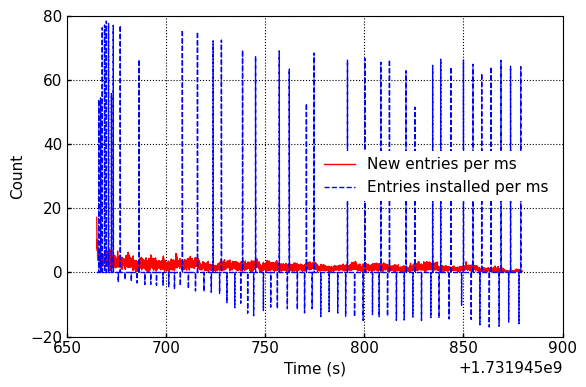

In [92]:
new_entry_cnt_ms = stats_df['replied_flow_count_tot'].diff()[1:]
instal_entry_cnt_ms = stats_df['active_host_tbl_entry_count'].diff()[1:]
# removed_entry_cnt_ms = stats_df['removed_entry_count_tot'].diff()[1:]
time_diff = stats_df['time'].diff()[1:] * 1000
new_entry_cnt_ms = new_entry_cnt_ms / time_diff
instal_entry_cnt_ms = instal_entry_cnt_ms / time_diff

fastplot.plot([('New entries per ms', (stats_df['time'][1:], new_entry_cnt_ms)),
                ('Entries installed per ms', (stats_df['time'][1:], instal_entry_cnt_ms))],
                None,
                mode='line_multi',
                legend=True, legend_loc='best',
                figsize=(6, 4), grid=True,
                xlabel='Time (s)', 
                ylabel='Count')
plt.show()

# Data Plane Resource Usage

## Table Entry Count

<Figure size 640x480 with 0 Axes>

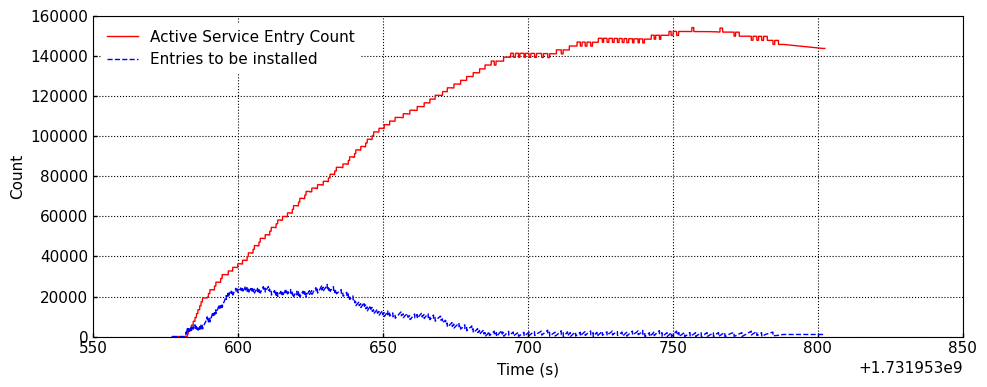

In [114]:

fastplot.plot([('Active Service Entry Count', (stats_df['time'], stats_df['active_host_tbl_entry_count'])),
               ('Entries to be installed', (stats_df['time'], stats_df['install_buf_size']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(10, 4), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')
plt.show()

# Network Speed Statistic

In [94]:
def bit_to_Gbit(bit):
    return bit / (1000 * 1000 * 1000)

def bit_to_Kbit(bit):
    return bit / (1000)

def bit_to_Mbit(bit):
    return bit / (1000 * 1000)

def byte_to_Gbit(byte):
    return byte * 8 / (1000 * 1000 * 1000)

In [95]:
net_stat_df_recv = pd.read_csv('../log/net_stat_recv.csv')
net_stat_df_recv['time'] = net_stat_df_recv['time'] - net_stat_df_recv['time'].min()
net_stat_df_recv = net_stat_df_recv[net_stat_df_recv['time'] < time_threshold]
net_stat_df_recv = net_stat_df_recv[net_stat_df_recv['bits_recv'] > 0]
net_stat_df_recv['bits_recv'] = net_stat_df_recv['bits_recv'].apply(bit_to_Gbit)
net_stat_df_recv['packets_recv'] = net_stat_df_recv['packets_recv'].apply(bit_to_Mbit)

net_stat_df_send = pd.read_csv('../log/2g_white/net_stat_send.csv')
net_stat_df_send['time'] = net_stat_df_send['time'] - net_stat_df_send['time'].min()
net_stat_df_send = net_stat_df_send[net_stat_df_send['time'] < time_threshold]
net_stat_df_send = net_stat_df_send[net_stat_df_send['bits_sent'] > 0]
net_stat_df_send['bits_sent'] = net_stat_df_send['bits_sent'].apply(bit_to_Gbit)
net_stat_df_send['packets_sent'] = net_stat_df_send['packets_sent'].apply(bit_to_Mbit)

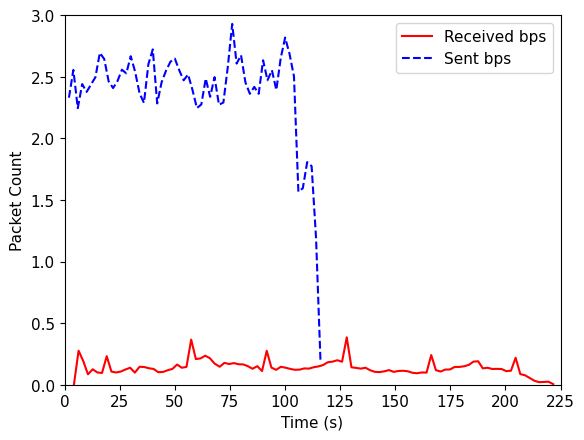

In [96]:
plt.plot(net_stat_df_recv['time'], net_stat_df_recv['bits_recv'], label='Received bps')
plt.plot(net_stat_df_send['time'], net_stat_df_send['bits_sent'], label='Sent bps')
plt.xlabel('Time (s)')
plt.ylabel('Packet Count')
plt.legend()
plt.show()

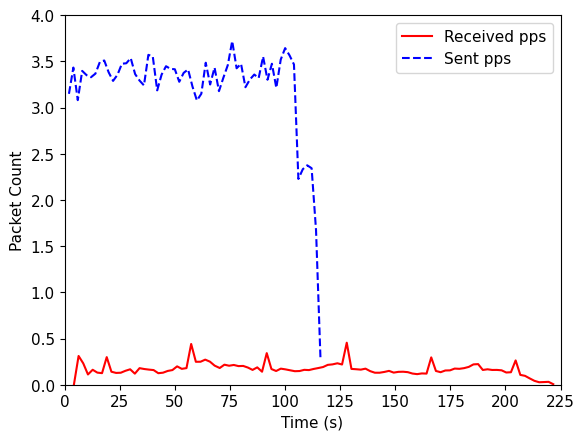

In [97]:
plt.plot(net_stat_df_recv['time'], net_stat_df_recv['packets_recv'], label='Received pps')
plt.plot(net_stat_df_send['time'], net_stat_df_send['packets_sent'], label='Sent pps')
plt.xlabel('Time (s)')
plt.ylabel('Packet Count')
plt.legend()
plt.show()

# CPU usage

In [98]:
net_stat_df_recv['mem_usage'] = net_stat_df_recv['mem_usage'].apply(bit_to_Gbit)

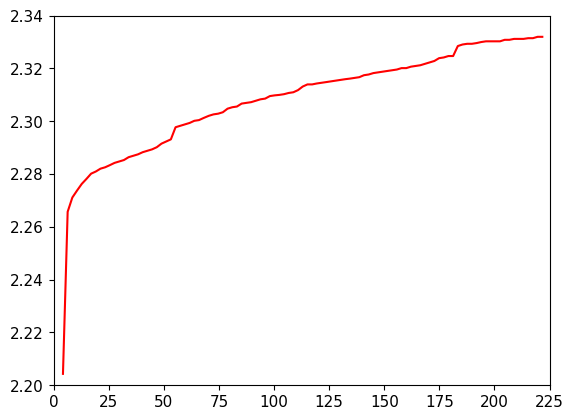

In [99]:
plt.plot(net_stat_df_recv['time'], net_stat_df_recv['mem_usage'], label='Memory Usage (GB)')

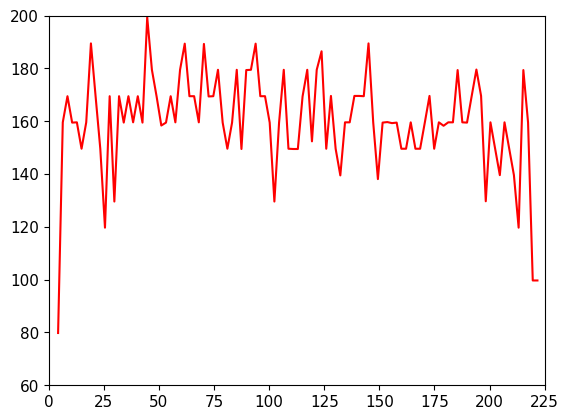

In [100]:
plt.plot(net_stat_df_recv['time'], net_stat_df_recv['cpu_usage'], label='CPU Usage (%)')
plt.show()